# Environment

#### - Tensorflow 2.0.0 beta1
#### - python3.7

## 載入套件

In [178]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

## 載入Tensorflow datasets套件

In [179]:
import tensorflow as tf
import tensorflow_datasets as tfds
print(tf.__version__)

2.0.0-beta1


## 建立資料夾路徑

`vocab_file`: 儲存中英文字典(vocabulary)路徑

`checkpoint`: 儲存模型路徑

`log_dir`: 記錄實驗結果

`download_dir`: 使用`wmt19`機器翻譯競賽的資料集，資料儲存路徑

In [298]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

## 查看wmt19 中英文對照資料集

* `newscommentary_v14`: 新聞評論
* `wikititles_v1`: wiki標題
* `uncorpus_v1`: 聯合國數據

In [299]:
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{NamedSplit('train'): ['newscommentary_v14',
                       'wikititles_v1',
                       'uncorpus_v1',
                       'casia2015',
                       'casict2011',
                       'casict2015',
                       'datum2015',
                       'datum2017',
                       'neu2017'],
 NamedSplit('validation'): ['newstest2018']}


## 透過`tf.DatasetBuilder`下載資料集

下載中英文的新聞評論資料集，會在`download_dir`下產生資料集，下次再執行就不需要使用`download_and_prepare`。

`builder.info`顯示資料集細節

In [300]:
config = tfds.translate.wmt.WmtConfig(
  version=tfds.core.Version('0.0.3', experiments={tfds.core.Experiment.S3: False}),
  language_pair=("zh", "en"),
  subsets={
    tfds.Split.TRAIN: ["newscommentary_v14"]
  }
)
builder = tfds.builder("wmt_translate", config=config)
# builder.download_and_prepare(download_dir=download_dir)
# clear_output()

W0817 16:27:15.906445 140702702389056 dataset_builder.py:689] Using custom data configuration zh-en


In [301]:
builder.info

tfds.core.DatasetInfo(
    name='wmt_translate',
    version=0.0.3,
    description='Translate dataset based on the data from statmt.org.

Versions exists for the different years using a combination of multiple data
sources. The base `wmt_translate` allows you to create your own config to choose
your own data/language pair by creating a custom `tfds.translate.wmt.WmtConfig`.

```
config = tfds.translate.wmt.WmtConfig(
    version="0.0.1",
    language_pair=("fr", "de"),
    subsets={
        tfds.Split.TRAIN: ["commoncrawl_frde"],
        tfds.Split.VALIDATION: ["euelections_dev2019"],
    },
)
builder = tfds.builder("wmt_translate", config=config)
```

',
    urls=['http://www.statmt.org'],
    features=Translation({
        'en': Text(shape=(), dtype=tf.string),
        'zh': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=311556,
    splits={
        'train': 311556,
    },
    supervised_keys=('zh', 'en'),
    citation="""""",
    redistribution_info=,
)

## 切割資料集
30%訓練集，1%測試集，其餘丟掉

In [302]:
train_perc = 30
val_prec = 1
drop_prec = 100 - train_perc - val_prec

split = tfds.Split.TRAIN.subsplit([train_perc, val_prec, drop_prec])
split

(NamedSplit('train')(tfds.percent[0:30]),
 NamedSplit('train')(tfds.percent[30:31]),
 NamedSplit('train')(tfds.percent[31:100]))

## 透過`tf.DatasetBuilder`載入資料

`assert`檢查型態

In [303]:
examples = builder.as_dataset(split=split, as_supervised=True)
train_examples, val_examples, _ = examples

assert isinstance(train_examples, tf.data.Dataset)
assert isinstance(val_examples, tf.data.Dataset)

# 顯示前10筆

因為原始`train_examples.take`原始是`tf.tensor` + `unicode`，透過`numpy()`轉字串，再透過`decode`轉`utf-8`

`take`每筆資料都是一個句子的中英對照

In [304]:
sample_examples = []
num_samples = 10

for en_t, zh_t in train_examples.take(num_samples):
    en = en_t.numpy().decode("utf-8")
    zh = zh_t.numpy().decode("utf-8")

    print(en)
    print(zh)
    print('-' * 10)

      # 之後用來簡單評估模型的訓練情況
    sample_examples.append((en, zh))

Making Do With More
多劳应多得
----------
If the Putins, Erdoğans, and Orbáns of the world want to continue to benefit economically from the open international system, they cannot simply make up their own rules.
如果普京、埃尔多安和欧尔班希望继续享有开放国际体系提供的经济利益，就不能简单地制定自己的规则。
----------
This ceiling can be raised only in a deep depression or other exceptional circumstances, allowing for counter-cyclical policy so long as it is agreed that the additional deficit is cyclical, rather than structural.
只有在发生深度萧条或其他反常事件时，这一上限才能做出调整，以便让反周期政策实施足够的长度，使人们一致认为增加的赤字是周期性的，而不是结构性的。
----------
Fascist and communist regimes of the past, which followed a similar instrumentalist approach to democracy, come to mind here.
在此我们想起了过去的法西斯主义和共产主义。 它们都相似地将民主作为实现其目的的工具。
----------
For nearly 70 years since then, the peninsula has been divided, and now it may be the world’s most dangerous flashpoint.
此后近70年来，朝鲜半岛一直处于分裂状态，如今它可能是全世界最危险的爆点。
----------
The eurozone’s collapse (and, for all practical purposes, that of the EU itself) force

## 使用`tfds.features.text.SubwordTextEncoder`載入與建立字典

* `.load_from_file`: 從`.subwords`檔案讀取字典
* `.build_from_corpus`: 建立`.subwords`字典

### 英文字典

Vocabulary大小為$8132$

In [305]:
%%time
try: 
    """
    嘗試讀取字典
    """
    subword_encoder_en = tfds.features.text.SubwordTextEncoder.load_from_file(en_vocab_file) 
    print('載入英文字典: %s' % en_vocab_file)
except: 
    """
    若沒有字典則建立字典
    (en.numpy() for en, _ in train_examples): 轉字串型態
    target_vocab_size :字典大小
    """
    print('建立字典: %s' % en_vocab_file)
    subword_encoder_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
        (en.numpy() for en, _ in train_examples),target_vocab_size = 2**13)
    subword_encoder_en.save_to_file(en_vocab_file)

建立字典: nmt/en_vocab
CPU times: user 1min 38s, sys: 7.3 s, total: 1min 45s
Wall time: 1min 12s


In [306]:
print('英文字典大小: %d' % subword_encoder_en.vocab_size)
print('英文字典前10個字:',subword_encoder_en.subwords[:10])

英文字典大小: 8132
英文字典前10個字: [', ', 'the_', 'to_', 'of_', 'and_', 's_', 'in_', 'a_', 'that_', 'is_']


#### 使用字典進行encode、decode

* `.encode`:編碼 (字 -> index)
* `.decode`:解碼 (index -> 字)

In [307]:
sample_string = 'Transformer is awesome.'
indices = subword_encoder_en.encode(sample_string)
indices

[2934, 457, 10, 2728, 138, 2281, 7922]

In [308]:
print('{0:10}{1:6}'.format('Index','Subword'))
for idx in indices:
    subword = subword_encoder_en.decode([idx])
    print('{0:5}{1:6}'.format(idx,' '*5 + subword))

Index     Subword
 2934     Trans
  457     former 
   10     is 
 2728     aw
  138     es
 2281     ome
 7922     .


### 中文字典
`max_subword_length=1`: 為了降低字典大小，以character為單位進行中文斷詞，原始預設是以詞為單位

Vocabulary大小為$4389$

In [309]:
%%time
try:
    subword_encoder_zh = tfds.features.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
    print('載入中文字典: %s' % zh_vocab_file)
except:
    print('建立字典: %s' % zh_vocab_file)
    subword_encoder_zh = tfds.features.text.SubwordTextEncoder.build_from_corpus(
        (zh.numpy() for _, zh in train_examples),
        target_vocab_size = 2**13,
        max_subword_length = 1)
    subword_encoder_zh.save_to_file(zh_vocab_file)

建立字典: nmt/zh_vocab
CPU times: user 9min 21s, sys: 7.22 s, total: 9min 29s
Wall time: 8min 55s


In [310]:
print('中文字典大小: %d' % subword_encoder_zh.vocab_size)
print('中文字典前10個字: %s' % subword_encoder_zh.subwords[:10])

中文字典大小: 4389
中文字典前10個字: ['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']


#### 使用字典進行encode、decode

* `.encode`:編碼 (字 -> index)
* `.decode`:解碼 (index -> 字)

In [311]:
sample_string = '多劳应多得'
indices = subword_encoder_zh.encode(sample_string)
indices

[49, 564, 114, 49, 80]

In [312]:
print('{0:10}{1:6}'.format('Index','Subword'))
for idx in indices:
    subword = subword_encoder_zh.decode([idx])
    print('{0:5}{1:6}'.format(idx,' '*5 + subword))

Index     Subword
   49     多
  564     劳
  114     应
   49     多
   80     得


In [313]:
next(iter(train_examples))

(<tf.Tensor: id=17925348, shape=(), dtype=string, numpy=b'Making Do With More'>,
 <tf.Tensor: id=17925349, shape=(), dtype=string, numpy=b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97'>)

## 添加`<BOS>`,`<EOS>`在句子頭尾

`.vocab_size`視為`<BOS>`, `.vocab_size+1`視為`<EOS>`

之後所有的訓練資料都需要通過`train_examples`產生，然後再透過`encode`轉成index

In [314]:
def encode(en_t, zh_t):
    
    en_indics = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
    zh_indics = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
    
    return en_indics, zh_indics

In [315]:
en_t, zh_t = next(iter(train_examples))
en_indics, zh_indics = encode(en_t, zh_t)

print('英文<BOS>: %d' % subword_encoder_en.vocab_size)
print('英文<EOS>: %d' % (subword_encoder_en.vocab_size + 1))
print('中文<BOS>: %d' % subword_encoder_zh.vocab_size)
print('中文<EOS>: %d' % (subword_encoder_zh.vocab_size + 1))

print('-' * 20)
print('Before encode: (two tensor): ')
print((en_t, zh_t))
print()
print('After encode: (two array): ')
print((en_indics, zh_indics))

英文<BOS>: 8132
英文<EOS>: 8133
中文<BOS>: 4389
中文<EOS>: 4390
--------------------
Before encode: (two tensor): 
(<tf.Tensor: id=17925357, shape=(), dtype=string, numpy=b'Making Do With More'>, <tf.Tensor: id=17925358, shape=(), dtype=string, numpy=b'\xe5\xa4\x9a\xe5\x8a\xb3\xe5\xba\x94\xe5\xa4\x9a\xe5\xbe\x97'>)

After encode: (two array): 
([8132, 5163, 17, 710, 7908, 300, 1646, 7977, 8133], [4389, 49, 564, 114, 49, 80, 4390])


## 將`encode`函數的輸出型態轉為計算圖的`Tensor`

如果直接將`train_examples`接上`encode`，會發生`'Tensor' object has no attribute 'numpy'`

這是因為`encode`的輸出不是`Eager Tensor`型態，需要透過`tf.py_function`轉成`Eager Tensor`

In [316]:
import traceback

try:
    train_examples.map(encode)
except AttributeError:
    traceback.print_exc()

Traceback (most recent call last):
  File "<ipython-input-316-dcc6eba68460>", line 4, in <module>
    train_examples.map(encode)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 1143, in map
    return MapDataset(self, map_func, preserve_cardinality=True)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 3226, in __init__
    use_legacy_function=use_legacy_function)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 2591, in __init__
    self._function = wrapper_fn._get_concrete_function_internal()
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 1366, in _get_concrete_function_internal
    *args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/eager/function.py", line 1360, in _get_concrete_function_internal_garbage_collected
    graph_function, _, _ = self._maybe_define_function(ar

### `tf.py_function`

`tf.py_function`能夠將函數輸出轉換成`Eager Tensor`

In [317]:
def tf_encode(en_t, zh_t):
    """
    從encode輸出的en_t及zh_t都不是Eager Tensor
    需要透過 tf.py_function 轉為Eager Tensor
    """
    return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))

print('After tf_encode: (two tensor)')
print(en_indices)
print(zh_indices)

After tf_encode: (two tensor)
tf.Tensor([8132 5163   17  710 7908  300 1646 7977 8133], shape=(9,), dtype=int64)
tf.Tensor([4389   49  564  114   49   80 4390], shape=(7,), dtype=int64)


### 限制句子長度

為了加快訓練速度，使用`tf.logical`限制中英文句子長度，並使用`.filter`過濾

In [318]:
max_length = 50
def filter_max_length(en_t, zh_t, max_length = max_length):
    
    return tf.logical_and(tf.size(en_t) <= max_length,
                          tf.size(zh_t) <= max_length)

tmp_dataset = tmp_dataset.filter(filter_max_length)

### Padding
指定batch_size以及padding

In [319]:
batch_size = 64
tmp_dataset = tmp_dataset.padded_batch(batch_size=batch_size, padded_shapes=([-1], [-1]))

en_batch, zh_batch = next(iter(tmp_dataset))

print('英文batch: ')
print(en_batch)
print('-' * 15)
print('中文batch: ')
print(zh_batch)

英文batch: 
tf.Tensor(
[[8132 5163   17 ...    0    0    0]
 [8132  163    2 ...    0    0    0]
 [8132 1691 4113 ...    0    0    0]
 ...
 [8132  131 3355 ...    0    0    0]
 [8132 1372    1 ...    0    0    0]
 [8132   18  973 ...    0    0    0]], shape=(64, 49), dtype=int64)
---------------
中文batch: 
tf.Tensor(
[[4389   49  564 ...    0    0    0]
 [4389   44  119 ...    3 4390    0]
 [4389    5   78 ...    0    0    0]
 ...
 [4389    7   30 ...    0    0    0]
 [4389  139  174 ...    0    0    0]
 [4389  173    4 ...    0    0    0]], shape=(64, 50), dtype=int64)


### 將`train_examples`與`val_examples`做同樣處理

* `train`:

 - `map(tf_encode)`: 將字串轉成index
 - `filter(filter_max_length)`:過濾長度
 - `cache()`: cache the dataset to memory to get a speedup while reading from it.
 - `shuffle(buffer_size)`: 打亂buffer裡的資料，確保隨機
 - `padded_batch(batch_size, padded_shapes=([-1],[-1]))`: padding長度
 - `prefetch(tf.data.experimental.AUTOUNE)`: 加速
 

Tensor-core pipeline: https://www.tensorflow.org/guide/performance/datasets?hl=zh_cn

In [320]:
max_length = 50
batch_size = 128
buffer_size = 15000

train_dataset = (train_examples
                 .map(tf_encode)
                 .filter(filter_max_length)
                 .cache()
                 .shuffle(buffer_size)
                 .padded_batch(batch_size, padded_shapes=([-1],[-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(batch_size, padded_shapes=([-1], [-1])))

In [321]:
en_batch, zh_batch = next(iter(train_dataset))

print('英文batch tensor: ')
print(en_batch)
print('-' * 20)
print('中文batch tensor: ')
print(zh_batch)

英文batch tensor: 
tf.Tensor(
[[8132 1993 5795 ...    0    0    0]
 [8132  417    1 ...    0    0    0]
 [8132 6226   50 ...    0    0    0]
 ...
 [8132 1438   35 ...    0    0    0]
 [8132 2093   38 ...    0    0    0]
 [8132  292   11 ...    0    0    0]], shape=(128, 50), dtype=int64)
--------------------
中文batch tensor: 
tf.Tensor(
[[4389  348  546 ...    0    0    0]
 [4389   29  302 ...    0    0    0]
 [4389  449  514 ...    0    0    0]
 ...
 [4389  120  238 ...    0    0    0]
 [4389    5   10 ...    0    0    0]
 [4389  120  238 ...    0    0    0]], shape=(128, 50), dtype=int64)


### 假設有新資料時的處理方式

1. `map(tf_encode)`: 轉成index
2. `filter(filter_max_length)`: 過濾最大長度
3. `padded_batch()`: padding

In [322]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]

batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

demo_examples = demo_examples.map(tf_encode).filter(filter_max_length).padded_batch(batch_size, padded_shapes=([-1],[-1]))

en_sample, zh_sample = next(iter(demo_examples))
print(en_sample)
print('-' * 15)
print(zh_sample)

tf.Tensor(
[[8132  103   10 1036 7922 8133    0    0]
 [8132   18 3992 5599   12 2477 7922 8133]], shape=(2, 8), dtype=int64)
---------------
tf.Tensor(
[[4389   10  239   82   28    3 4390    0    0    0]
 [4389  166  463  417  190   14    7  553    3 4390]], shape=(2, 10), dtype=int64)


# Transformer

<img src="img/1.png" alt="Drawing" style="width: 400px;"/>


## Positional Encoding

Word Embedding所表達的是所有詞向量之間的相似關係，而Transformer的做法是透過內積解決RNN的長距離依賴問題(long-range dependenices)，但是這樣做卻沒有考慮到句子中的詞先後順序關係，透過Positional Encoding，讓詞向量之間不只因為word embedding語義關係而靠近，也可以因為詞之間的位置相互靠近而靠近。

$$
PE_{(pos,2i)} = \sin(pos/10000^{\frac{2i}{d_{model}}}) \\
PE_{(pos,2i+1)} = \cos(pos/10000^{\frac{2i}{d_{model}}})
$$

#### 之後可以調整看看三角函數的參數，例如10000 -> 100

In [323]:
# 先建立角度
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, 2 * (i//2) / np.float32(d_model))
    return pos * angle_rates

# 生成 2i和 2i+1的角度
position = 50
d_model = 512
pos = np.arange(position)[:, np.newaxis]
i = np.arange(d_model)[np.newaxis, :]

get_angles(pos, i, d_model) # (50, 512)

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.00000000e+00, 9.64661620e-01, ...,
        1.07460783e-04, 1.03663293e-04, 1.03663293e-04],
       [2.00000000e+00, 2.00000000e+00, 1.92932324e+00, ...,
        2.14921566e-04, 2.07326586e-04, 2.07326586e-04],
       ...,
       [4.70000000e+01, 4.70000000e+01, 4.53390961e+01, ...,
        5.05065679e-03, 4.87217476e-03, 4.87217476e-03],
       [4.80000000e+01, 4.80000000e+01, 4.63037578e+01, ...,
        5.15811758e-03, 4.97583806e-03, 4.97583806e-03],
       [4.90000000e+01, 4.90000000e+01, 4.72684194e+01, ...,
        5.26557836e-03, 5.07950135e-03, 5.07950135e-03]])

In [324]:
def positional_encoding(position, d_model):
    """
    奇數sin
    偶數cos
    
          第一個字: [[sin(0),cos(0),sin(1),cos(1),...,sin(d_model-1),cos(d_model)]
          第二個字: ,[sin(0),cos(0),sin(1),cos(1),...,sin(d_model-1),cos(d_model)]
          第三個字: ,[sin(0),cos(0),sin(1),cos(1),...,sin(d_model-1),cos(d_model)]
          ...     
    第position個字: ,[sin(0),cos(0),sin(1),cos(1),...,sin(d_model-1),cos(d_model)]]
    
    return:
    (batch_size, position, d_model)
    """
    pos = np.arange(position)[:, np.newaxis] # [[0],[1],[2],...,[pos-1]]
    i = np.arange(d_model)[np.newaxis, :] # [[0,1,2,3,...,d_model-1]]
    
    angle_rads = get_angles(pos, i, d_model) # (position, d_model)
    
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    pos_encoding = angle_rads[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


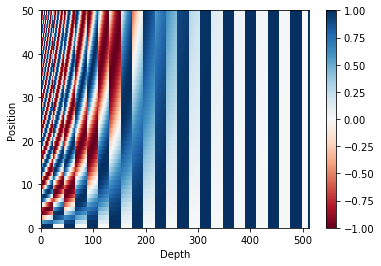

In [325]:
pos_encoding = positional_encoding(position, d_model)
print(pos_encoding.shape)
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

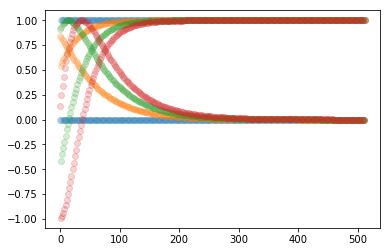

In [326]:
plt.plot(pos_encoding.numpy()[0][0], 'o',alpha = 0.2) # w1
plt.plot(pos_encoding.numpy()[0][1], 'o',alpha = 0.2) # w2
plt.plot(pos_encoding.numpy()[0][2], 'o',alpha = 0.2) # w3
plt.plot(pos_encoding.numpy()[0][3], 'o',alpha = 0.2) # w4
plt.show()

## Masking
在Transformer中有兩個地方需要進行masking，以下兩種masking的方式都是先指定要進行masking的位置，然後將內積過後的attetion matrix進行masking。

 1. `Padding_masking`: 句子padding的部分不需要被transformer注意到，透過mask，讓self-attention出來的weight接近0。
 2. `Look_head_masking`: Decoder中的masked self attention會使用到，不讓當前的字去注意到之後所有的字，一樣是讓self-attention出來的weight接近0。
 
### Padding masking

In [327]:
def create_paddding_mask(seq):
    """
    Input:
    在字典中，padding的index為0
    
    所以當Input遇到0時就將其變為1，之後當成要進行masking的index
    
    Return:
    在中間插上兩個維度是為了後面attention時做broadcasting
    """
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

In [328]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
print(x)
print(create_paddding_mask(x))
# 1的位置就是要進行masking的位置

tf.Tensor(
[[7 6 0 0 1]
 [1 2 3 0 0]
 [0 0 0 4 5]], shape=(3, 5), dtype=int32)
tf.Tensor(
[[[[0. 0. 1. 1. 0.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(3, 1, 1, 5), dtype=float32)


### Look ahead masking

In [329]:
def create_look_ahead_mask(size):
    """
    Input: 方陣size，以transformer來說就是self-attention的weigh matrix，將上三角進行masking
    
    tf.linalg.band_part(input, num_lower, num_upper)
    num_lower, num_upper: 從主對角線開始決定mask的起點，-1表示保留原值
    """
    mask = 1 - tf.linalg.band_part(tf.ones((size,size)), -1, 0)
    return mask

In [330]:
create_look_ahead_mask(3)

<tf.Tensor: id=18064658, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

### Scaled dot-product attention(self-attention)

<img src="img/3.png" alt="Drawing" style="width: 200px;"/>

1. Q與K進行矩陣相乘的地方就是實現Self-attention的地方，表示Q中的每個字對於K的每個字的attention。
2. 接著進行Scale是為了避免後面通過Softmax之後的attention weight不是1就是0，這樣會造成很小的梯度(hard softmax)。
3. 通過Softmax之後就產生attention weight matrix，再乘上V，最後得到Context matrix。

$$
\mathrm{Attention}(Q,K,V) = \mathrm{Softmax}(\frac{QK^\top}{\sqrt{d_k}})V
$$

In [331]:
def scaled_dot_product_attention(q, k, v, mask):
    """
    Args:
        q: query shape == (..., seq_len_q, depth_k)
        k: key shape == (..., seq_len_k, depth_k)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k)
    """
    # q,k矩陣相乘
    matmul_qk = tf.matmul(q, k, transpose_b=True) # (..., q_dim, k_dim)
    
    # Scaled
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # mask
    if mask is not None:
        scaled_attention_logits += (mask * -1*9)
    # Softmax最後一個維度(k_dim)，表示每個字對於所有字的attention weights    
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis = -1) 
    
    output = tf.matmul(attention_weights, v) # (..., q_dim, depth_v)
    
    return attention_weights, output

In [332]:
"""
假設一個字(query)對四個字(key)進行self attention，得到attention weight之後再與value相乘
"""

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32) # (1, 3)

attention_weights, output = scaled_dot_product_attention(temp_q, temp_k, temp_v, mask=None)

In [333]:
print('Attention weights: ')
print(attention_weights)
print()
print('Ouptut: ')
print(output)

Attention weights: 
tf.Tensor([[8.433274e-26 1.000000e+00 8.433274e-26 8.433274e-26]], shape=(1, 4), dtype=float32)

Ouptut: 
tf.Tensor([[1.000000e+01 9.276601e-25]], shape=(1, 2), dtype=float32)


In [334]:
"""
假設四個字(query)對四個字(key)進行self attention，然後將上三角形進行mask，得到attention weight之後再與value相乘

將右上角mask掉之後觀察attention weights會發現上三角形的weigh趨近於0
"""

# 為了方便觀察weight，將temp_q都設為1
temp_q = tf.constant([[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=tf.float32) # (4, 3)

mask = create_look_ahead_mask(temp_q.shape[0])

attention_weights, output = scaled_dot_product_attention(temp_q, temp_k, temp_v, mask=mask)

In [335]:
print('Attention weights: ')
print(attention_weights)
print()
print('Ouptut: ')
print(output)

Attention weights: 
tf.Tensor(
[[9.9962997e-01 1.2336414e-04 1.2336414e-04 1.2336414e-04]
 [4.9993831e-01 4.9993831e-01 6.1697290e-05 6.1697290e-05]
 [3.3331960e-01 3.3331960e-01 3.3331960e-01 4.1134906e-05]
 [2.5000000e-01 2.5000000e-01 2.5000000e-01 2.5000000e-01]], shape=(4, 4), dtype=float32)

Ouptut: 
tf.Tensor(
[[1.1365643e+00 1.3570056e-03]
 [5.5671883e+00 6.7867019e-04]
 [3.7039608e+01 1.6668448e+00]
 [2.7775000e+02 2.7500000e+00]], shape=(4, 2), dtype=float32)


### Multi-Head Attention

<img src="img/2.png" alt="Drawing" style="width: 300px;"/>

將`q,k,v`分成num_heads份，各自做self-attention，然後再concat，通過dense輸出，分成num_heads的優點最主要是希望讓每個head各自注意到Sequence中不同的地方

In [336]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 確保d_model可以被num_heads整除
        assert d_model % self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """
        將d_model切割成(num_heads, depth)
        為了後面做self-attention，transpose成(batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def __call__(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q) # (batch_size, seq_len, d_model) 
        k = self.wk(k) # (batch_size, seq_len, d_model) 
        v = self.wv(v) # (batch_size, seq_len, d_model) 
        
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size) # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size) # (batch_size, num_heads, seq_len_v, depth)
        
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        attention_weights, scaled_attention = scaled_dot_product_attention(q, k, v, mask) 
        
        #為了將num_heads進行concat，transpose成(batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 
        
        # 合併後面兩維度 (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        
        output = self.dense(concat_attention)
        
        return output, attention_weights

In [337]:
y = tf.random.uniform((1, 60, 512)) # (batch_size, seq_len, d_model)

d_model = 512
num_heads = 8
temp_mha = MultiHeadAttention(d_model, num_heads)
output, attention_weights = temp_mha(v=y, k=y, q=y, mask=None)

In [338]:
# 輸出仍然是 (batch_size, seq_len, d_model)
print('output shape', output.shape)

# 8個heads各自有一個attention weight matrix
print('attention_weights shape: ', attention_weights.shape)

output shape (1, 60, 512)
attention_weights shape:  (1, 8, 60, 60)


### Point-wise feed forward network

$$
FFN(x) = max(0, xW_1 + b_1)W_2+b_2
$$

In [339]:
def point_wise_ffn(d_model, dff):
    return tf.keras.Sequential([tf.keras.layers.Dense(dff, activation='relu'), # (batch_size, seq_len, dff)
                                tf.keras.layers.Dense(d_model)]) # (batch_size, seq_len, d_model)

In [340]:
d_model = 512
dff = 2048
sample_ffn = point_wise_ffn(d_model, dff)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

### Encoderblock and Decoderblock

<img src="img/1.png" alt="Drawing" style="width: 400px;"/>


#### `EncoderLayer`
`MultiHeadAttention` + `Residual connection` + `Layer Normalization` + `Dropout`

In [341]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate = 0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_ffn(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
    def __call__(self, x, training, mask):
        # 不需要看Encoder的attention weight
        attention_output, _ = self.mha(v = x, k = x, q = x, mask=mask) # (batch_size, input_seq_len, d_model)
        # Inference時不需要使用dropout
        attention_output = self.dropout1(attention_output, training=training) # (batch_size, input_seq_len, d_model)
        # Residual + Layer Normalization
        out1 = self.layernorm1(x + attention_output) # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1) # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training) # (batch_size, input_seq_len, d_model)
        enc_output = self.layernorm2(out1 + ffn_output) # (batch_size, input_seq_len, d_model)

        return enc_output

In [342]:
d_model = 512
num_heads = 8
dff = 2048
dropout_rate = 0.1

sample_encooder_layer = EncoderLayer(d_model, num_heads, dff, dropout_rate)

x = tf.random.uniform((64, 50, 512))
training = False
mask = None

sample_encooder_layer_output = sample_encooder_layer(x, training, mask)
sample_encooder_layer_output.shape

TensorShape([64, 50, 512])

#### `DecoderLayer`
`MultiHeadAttention(look_ahead_mask, padding_mask)` + `Residual connection` + `Layer Normalization` + `Dropout`

In [343]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate = 0.1):
        super().__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_ffn(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout3 = tf.keras.layers.Dropout(dropout_rate)
        
    def __call__(self, x, enc_output, training, look_ahead_mask, padding_mask):
        
        # masked self-attention，後面需要觀察attention weight matrix
        # 使用look_ahead_mask，讓decoder輸入只能往前看
        attention_output1, masked_attention_weights = self.mha1(v=x, k=x, q=x, mask=look_ahead_mask) # (batch_size, ouptut_seq_len, d_model)
        attention_output1 = self.dropout1(attention_output1, training=training) # (batch_size, ouptut_seq_len, d_model)
        attention_output1 = self.layernorm1(x + attention_output1) # (batch_size, ouptut_seq_len, d_model)
        
        # 使用padding_mask，忽略padding的attention weights，不讓任何字去注意到padding的位置
        attention_output2, dec_attention_weights = self.mha1(v=enc_output, k=enc_output, q=attention_output1, mask=padding_mask) # (batch_size, ouptut_seq_len, d_model)
        attention_output2 = self.dropout2(attention_output2, training=training) # (batch_size, ouptut_seq_len, d_model)
        attention_output2 = self.layernorm2(attention_output1 + attention_output2) # (batch_size, ouptut_seq_len, d_model)
        
        ffn_output = self.ffn(attention_output2)
        ffn_output = self.dropout3(ffn_output, training=training)
        dec_output = self.layernorm3(attention_output2 + ffn_output)
        
        return dec_output, masked_attention_weights, dec_attention_weights

In [344]:
d_model = 512
num_heads = 8
dff = 2048
dropout_rate = 0.1

x = tf.random.uniform((64, 60, 512))
training = False
look_ahead_mask = None
padding_mask = None

sample_decoder_layer = DecoderLayer(d_model, num_heads, dff, dropout_rate)
sample_dec_output, masked_attention_weights, dec_attention_weights = sample_decoder_layer(x, sample_encooder_layer_output, training, look_ahead_mask, padding_mask)

In [345]:
# (batch_size, output_seq_len, d_model)
print('dec_output shape: ', sample_dec_output.shape)
# (batch_size, num_heads, output_seq_len, output_seq_len)
print('masked_attention_weights shape: ', masked_attention_weights.shape)
# (batch_size, num_heads, output_seq_len, Input_seq_len)
print('dec_attention_weights shape: ', dec_attention_weights.shape)

dec_output shape:  (64, 60, 512)
masked_attention_weights shape:  (64, 8, 60, 60)
dec_attention_weights shape:  (64, 8, 60, 50)


## Encoder

建立`Encoder`的pipeline，`Word embedding` + `Positional encoding` + `Encoder Layer * num_layers`

In [346]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate=0.1):
        super().__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, self.d_model)
        self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.enc_layers = [EncoderLayer(self.d_model, num_heads, dff, dropout_rate) for _ in range(self.num_layers)]
    
    def __call__(self, x, training, mask):

        seq_len = tf.shape(x)[1]
        
        x = self.embedding(x) # (batch_size, seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :] # (batch_size, seq_len, d_model)
        
        x = self.dropout(x, training=training) # (batch_size, seq_len, d_model)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask) # (batch_size, seq_len, d_model)
            
        return x

In [347]:
num_layers = 2
d_model = 512
num_heads = 8
dff = 2048
input_vocab_size = 10000
dropout_rate = 0.1

sample_encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate)

# 模擬輸入64個句子，每個句子padding成50個字
x = tf.random.uniform((64, 50))
training = False
mask = None

sample_encoder_output = sample_encoder(x, training, mask)
# (batch_size, input_seq_len, d_model)
print('sample_encoder_output shape: ',sample_encoder_output.shape)

sample_encoder_output shape:  (64, 50, 512)


## Decoder

建立`Decoder`的pipeline，`Word embedding` + `Positional encoding` + `Decoder Layer * num_layers`

因為要觀察`masked_attention_weights`以及`dec_attention_weight`，所以另外寫一個`attention_weights`儲存

In [348]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, output_vocab_size, dropout_rate = 0.1):
        super().__init__()
        
        self.num_layers = num_layers
        self.d_model = d_model
        
        self.embedding = tf.keras.layers.Embedding(output_vocab_size, d_model)
        self.pos_encoding = positional_encoding(output_vocab_size, d_model)
        
        self.dec_layers = [DecoderLayer(self.d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def __call__(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}
        
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        
        x = self.dropout(x, training=training)
        
        for i in range(self.num_layers):
            # x.shape: (batch_size, output_seq_len, d_model)
            x, masked_attention_weights, dec_attention_weights = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
            
            # masked attention: (batch_size, num_head, output_seq_len, output_seq_len)
            # dec attention: (batch_size, num_head, output_seq_len, input_seq_len)
            attention_weights['decoder_layer{}_masked_attention_weights'.format(i + 1)] = masked_attention_weights
            attention_weights['decoder_layer{}_dec_attention_weights'.format(i + 1)] = dec_attention_weights
            
        return x, attention_weights

In [349]:
num_layers = 2
d_model = 512
num_heads = 8
dff = 2048
output_vocab_size = 10000
dropout_rate = 0.1

sample_decoder = Decoder(num_layers, d_model, num_heads, dff, output_vocab_size, dropout_rate)

# 模擬輸入64個句子，每個句子padding成20個字
x = tf.random.uniform((64, 20))
training = False
look_ahead_mask = None
padding_mask = None

sample_decoder_output, attention_weights = sample_decoder(x, sample_encoder_output, training, look_ahead_mask, padding_mask)

# (batch_size, output_seq_len, d_model)
print('sample_decoder_output shape:', sample_decoder_output.shape)

# masked attention: (batch_size, num_head, output_seq_len, output_seq_len)
# dec attention: (batch_size, num_head, output_seq_len, input_seq_len) 
# dec attention表示 output_seq對input_seq的注意力
for key, value in attention_weights.items():
    print(key, ' :', value.shape)

sample_decoder_output shape: (64, 20, 512)
decoder_layer1_masked_attention_weights  : (64, 8, 20, 20)
decoder_layer1_dec_attention_weights  : (64, 8, 20, 50)
decoder_layer2_masked_attention_weights  : (64, 8, 20, 20)
decoder_layer2_dec_attention_weights  : (64, 8, 20, 50)


## Transformer

結合`Encoder`和`Decoder`，接上最後的`Dense`，輸出probability 

In [350]:
class Transformer(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, output_vocab_size, dropout_rate = 0.1):
        super().__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, dropout_rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff, output_vocab_size, dropout_rate)
        
        self.final_layer = tf.keras.layers.Dense(output_vocab_size)
        
    def __call__(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        # enc_output.shape: (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training, mask) 

        # dec_output.shape: (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, padding_mask)

        # final_output.shape: (batch_szie, tar_seq_len, output_vocab_size )
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [351]:
num_layers = 2
d_model = 512
num_heads = 8
dff = 2048
input_vocab_size = 10000
output_vocab_size = 10000
dropout_rate = 0.1


sample_transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, output_vocab_size, dropout_rate)

# Input: 模擬輸入64個句子，每個句子padding成50個字
# Target: 模擬輸入64個句子，每個句子padding成20個字
temp_input = tf.random.uniform((64, 50))
temp_target = tf.random.uniform((64, 20))
training = False
enc_padding_mask = None
look_ahead_mask = None
dec_padding_mask = None

final_output, attention_weights = sample_transformer(temp_input, temp_target, training, enc_padding_mask, look_ahead_mask, dec_padding_mask)

print('final_output shape:', final_output.shape)

# masked attention: (batch_size, num_head, output_seq_len, output_seq_len)
# dec attention: (batch_size, num_head, output_seq_len, input_seq_len) 
# dec attention表示 output_seq對input_seq的注意力
for key, value in attention_weights.items():
    print(key, ' :', value.shape)

final_output shape: (64, 20, 10000)
decoder_layer1_masked_attention_weights  : (64, 8, 20, 20)
decoder_layer1_dec_attention_weights  : (64, 8, 20, 50)
decoder_layer2_masked_attention_weights  : (64, 8, 20, 20)
decoder_layer2_dec_attention_weights  : (64, 8, 20, 50)


## Optimizer and Customer Learning rate
論文使用`Adam`搭配客製化的`Learning rate`，`Learning rate`在warmup_steps前遞增，在warmup_step後遞減。

$$
lrate = d^{-0.5}_{model}\times min(step\_num^{-0.5},\;step\_num \times warmup\_steps^{-1.5})
$$

In [352]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        
        self.d_model = tf.cast(d_model, tf.float32) ** -0.5
        
        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        
        arg1 = step ** -0.5 # step_num^{-0.5}
        arg2 = step * (self.warmup_steps ** -1.5) # step_num * warmup_step^{-1.5}
        
        return self.d_model * tf.math.minimum(arg1, arg2)

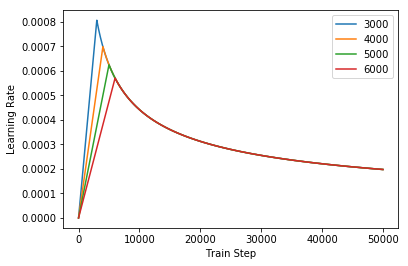

In [353]:
d_models = 512
warmup_steps = [3000 ,4000, 5000, 6000]

step = tf.range(50000, dtype=tf.float32)

for warmup_step in warmup_steps:
    temp_learning_rate_schedule = CustomSchedule(d_model, warmup_step)
    plt.plot(temp_learning_rate_schedule(step), label = str(warmup_step))
    plt.ylabel('Learning Rate')
    plt.xlabel('Train Step')
    plt.legend(loc='upper right',)


In [354]:
d_model = 512
warmup_steps = 4000
learning_rate = CustomSchedule(d_model, warmup_steps)

beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-9
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

### Loss and metrics

不需要計算padding位置的loss，所以需要進行mask

In [355]:
def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0)) # 將sequence中padding(index為0)的部分設為True
    
    """
    from_logits: y_pred is expected to be a logits tensor. By default, we assume that y_pred encodes a probability distribution.
    reduction: the reduction schedule of output loss vectors. `https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses/Reduction`
    """
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask # 只計算非padding的loss
    
    return tf.reduce_mean(loss_)

In [356]:
# Loss sample
cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

y_true = tf.constant([0, 1, 0], dtype=tf.float32)
y_pred = tf.constant([[.95, .05], [.11, .89], [.05, .95]], dtype=tf.float32)

loss = cce(y_true, y_pred)
print('Loss: ', loss.numpy())  # Loss:  0.6532173

Loss:  [0.34115392 0.37734404 1.241154  ]


In [357]:
# 記錄train_loss與train_accuracy
train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

### Create masking

建立訓練時`Encoder`和`Decoder`需要用到的masking

* `Encoder`: 
  - 第一個Multi-head attention需要Input的`padding_mask`


* `Decoder`: 
  - 第一個Masked Multi-head attention需要Target的`padding_mask` + `look_ahead_mask`
  - 第二個Multi-head attention需要Input的`padding_mask`

In [358]:
def create_masks(inp, tar):
    
    # Encoder padding mask
    enc_padding_mask = create_paddding_mask(inp)
    
    # Decoder 2nd Multi-head attention
    dec_padding_mask = create_paddding_mask(inp)
    
    # Decoder 1st Masked Multi-head attention
    look_ahead_mask = create_look_ahead_mask(size=tf.shape(tar)[1]) # 建立只能往前看的mask矩陣
    dec_target_padding_mask = create_paddding_mask(tar) # padding_mask
    combined_mask = tf.maximum(look_ahead_mask, dec_target_padding_mask) # 返回兩者各別最大的值，也就是都是1的位置
    
    return enc_padding_mask, combined_mask, dec_padding_mask

### Set Parameters

In [500]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = subword_encoder_en.vocab_size + 2
output_vocab_size = subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1

epochs = 30

### Checkpoint

In [501]:
transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, output_vocab_size, dropout_rate)

run_id = f'{num_layers}layers_{d_model}d_model_{num_heads}heads_{dff}dff'
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

ckpt = tf.train.Checkpoint(transformer = transformer, optimizer = optimizer)
# 只保留最近3次訓練結果
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# 檢查在checkpoint_path上是否有已訓練的checkpoint，有就叫ckpt進行讀取
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored')

### Define training step

In [502]:
@tf.function # 將自訂函數轉換為 TF計算圖，加速運算
def train_step(inp, tar):
    
    # teacher forcing
    tar_inp = tar[:, :-1] # Deocder的target輸入不需要<EOS>
    tar_real = tar[:, 1:] # Decdoer的target輸出不需要<BOS>
    
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    
    # 記錄梯度，之後做梯度下降
    Training = True
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp, Training, enc_padding_mask, look_ahead_mask, dec_padding_mask)
        loss = loss_function(tar_real, predictions)
    
    # 拿出所有可訓練參數的gradient
    gradients = tape.gradient(loss, transformer.trainable_variables)
    # 呼叫Adam透過gradient更新參數
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # 輸出loss以及acc，之後準備給Tensorboard記錄
    train_loss(loss)
    train_accuracy(tar_real, predictions)

### Training

In [503]:
print(f'Training on {num_layers}num_layers, {d_model}d_model, {num_heads}num_heads')

# Tensorboard
summary_writer = tf.summary.create_file_writer(logdir=log_dir)

for epoch in range(epochs):
    start = time.time()
    
    # 每次epoch重置Tensorboard metrics
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    # 依序訓練所有batch
    for (batch, (inp, tar)) in enumerate(train_dataset):
        train_step(inp, tar)
    
    # 每5個epoch就儲存模型
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print('Saving checkpoint for epoch {} at {}'.format(epoch+1, ckpt_save_path))
        
    with summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch+1)
        tf.summary.scalar('train_acc', train_accuracy.result(), step=epoch+1)
        
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch+1, train_loss.result(), train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time()-start))


Training on 4num_layers, 128d_model, 8num_heads
Epoch 1 Loss 2.9924 Accuracy 0.1757
Time taken for 1 epoch: 271.3057725429535 secs

Epoch 2 Loss 0.2326 Accuracy 0.6004
Time taken for 1 epoch: 54.687644958496094 secs

Epoch 3 Loss 0.0329 Accuracy 0.6269
Time taken for 1 epoch: 54.53213310241699 secs

Epoch 4 Loss 0.0144 Accuracy 0.6290
Time taken for 1 epoch: 54.49001932144165 secs

Saving checkpoint for epoch 5 at nmt/checkpoints/4layers_128d_model_8heads_512dff/4layers_128d_model_8heads_512dff/ckpt-1
Epoch 5 Loss 0.0089 Accuracy 0.6297
Time taken for 1 epoch: 54.53795075416565 secs

Epoch 6 Loss 0.0062 Accuracy 0.6300
Time taken for 1 epoch: 54.3950560092926 secs

Epoch 7 Loss 0.0047 Accuracy 0.6302
Time taken for 1 epoch: 54.340949296951294 secs

Epoch 8 Loss 0.0037 Accuracy 0.6304
Time taken for 1 epoch: 54.462674617767334 secs

Epoch 9 Loss 0.0029 Accuracy 0.6305
Time taken for 1 epoch: 54.315585136413574 secs

Saving checkpoint for epoch 10 at nmt/checkpoints/4layers_128d_model_8h

## Evaluate

當有新sentence要預測時，sentence一樣要做與encoder輸入的處理: 

1. Encoder輸入前後需要增加`<BOS>`與`<EOS>`
2. Decoder的預測方式是用AutoRegressive，輸入是從`<BOS>`開始預測，第一次預測完將預測結果concat在`<BOS>`後，之後以此類推。

`<BOS>` => `<BOS> 我` => `<BOS> 我 好 ` => `<BOS> 我 好 帥`

In [504]:
def evaluate(inp_sentence):
    
    start_token = [subword_encoder_en.vocab_size]
    end_token = [subword_encoder_en.vocab_size + 1]
    
    # Encoder的輸入需要增加<BOS>,<EOS>
    inp_sentence = start_token + subword_encoder_en.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, axis=0)
    
    # Decoder的預測方式是autoregressive，即從<BOS>開始預測，每次預測完拿取預測結果最後一個字的概率
    decoder_input = [subword_encoder_zh.vocab_size]
    output = tf.expand_dims(decoder_input, axis=0)
    
    # AutoRegressive
    Training = False
    for i in range(max_length):
        # create mask
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
        
        # prediction.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, output, Training, enc_padding_mask, combined_mask, dec_padding_mask)
        
        # 拿取最後一個字作為預測結果
        prediction = predictions[:, -1:, :]
        
        prediction_id = tf.cast(tf.argmax(prediction, axis = -1), tf.int32)
        
        # 預測結果遇到<EOS>就停止回傳output
        if prediction_id == (subword_encoder_zh.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights
        
        output = tf.concat([output, prediction_id], axis = -1)
        
    return tf.squeeze(output, axis=0), attention_weights, predictions

In [529]:
sentence = [i for i in inp[4] if i < subword_encoder_en.vocab_size]
sentence =  subword_encoder_en.decode(sentence)

predicted_seq, attention_weights, predictions = evaluate(sentence)

In [526]:
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < subword_encoder_zh.vocab_size]
predicted_sentence = subword_encoder_zh.decode(predicted_seq_without_bos_eos)

## Visualization

畫出`Decoder`中的self-attention權重矩陣，這裏挑最後一層的`dec_attention_weights`作為attention。

In [463]:
for key,value in attention_weights.items():
    print(key,':',value.shape)
    
layer_name = 'decoder_layer4_dec_attention_weights'

decoder_layer1_masked_attention_weights : (1, 8, 50, 50)
decoder_layer1_dec_attention_weights : (1, 8, 50, 29)
decoder_layer2_masked_attention_weights : (1, 8, 50, 50)
decoder_layer2_dec_attention_weights : (1, 8, 50, 29)
decoder_layer3_masked_attention_weights : (1, 8, 50, 50)
decoder_layer3_dec_attention_weights : (1, 8, 50, 29)
decoder_layer4_masked_attention_weights : (1, 8, 50, 50)
decoder_layer4_dec_attention_weights : (1, 8, 50, 29)


In [498]:
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    
    fig = plt.figure(figsize=(17, 14))

    sentence = subword_encoder_en.encode(sentence)

    # 只顯示中文序列前 `max_len_tar` 個字以避免畫面太過壅擠
    if max_len_tar:
        predicted_seq = predicted_seq[:max_len_tar]
    else:
        max_len_tar = len(predicted_seq)

    # 將某一個特定 Decoder layer 裡頭的 MHA 1 或 MHA2 的注意權重拿出來並去掉 batch 維度
    attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
    # (num_heads, tar_seq_len, inp_seq_len)

    # 只畫其中4個head
    attention_weights = attention_weights[4:8,:,:]
    
    # 將每個 head 的注意權重畫出
    for head in range(attention_weights.shape[0]):
        ax = fig.add_subplot(2, 2, head + 1)

        # [注意]我為了將長度不短的英文子詞顯示在 y 軸，將注意權重做了 transpose
        attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
        ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)

        ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
        ax.set_xlim(-0.5, max_len_tar -1.5)

        ax.set_yticks(range(len(sentence) + 2))
        ax.set_xticklabels([subword_encoder_zh.decode([i]) for i in predicted_seq 
                            if i < subword_encoder_zh.vocab_size], fontsize=18)    

        ax.set_yticklabels(
            ['<start>'] + [subword_encoder_en.decode([i]) for i in sentence] + ['<end>'])

        ax.set_xlabel('Head {}'.format(head + 1), fontsize=15)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

<Figure size 1440x1080 with 0 Axes>

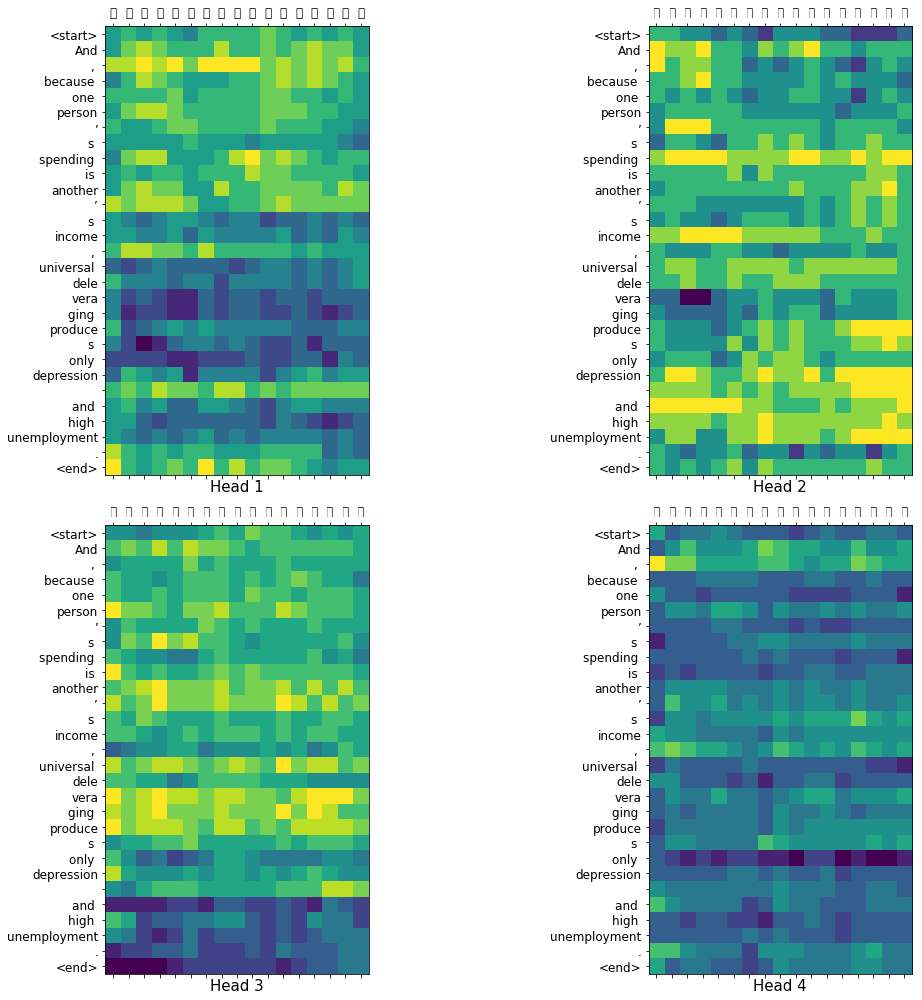

In [499]:
plt.figure(figsize=(20,15))
plot_attention_weights(attention_weights, sentence, 
                       predicted_seq, layer_name, max_len_tar=18)